In [1]:
## Imports

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Input, Dense, Conv1D, MaxPooling1D,
                                     Dropout, concatenate, Flatten,
Activation, BatchNormalization) 
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import seaborn as sns
import os

Llegim les dades.

In [2]:
data_train = pd.read_csv('train_data.csv', index_col=0)

Separem variables predictores de la classe a predir.

In [3]:
x_train = data_train.drop('ECG_signal', axis=1)
y_train = data_train.ECG_signal

Escalo les dades (fa que *backpropagation* vagi millor). Utilitzo *Z-Score Normalization*, i.e.

$$
Z = \frac{X - \mu}{\sigma}
$$

per a que les varibles tinguin mitjana $0$ i desviació estàndard $1$.

In [4]:
zscore_scaler = StandardScaler()

zscore_scaler.fit(x_train)

x_train = zscore_scaler.transform(x_train)

x_train = pd.DataFrame(x_train)

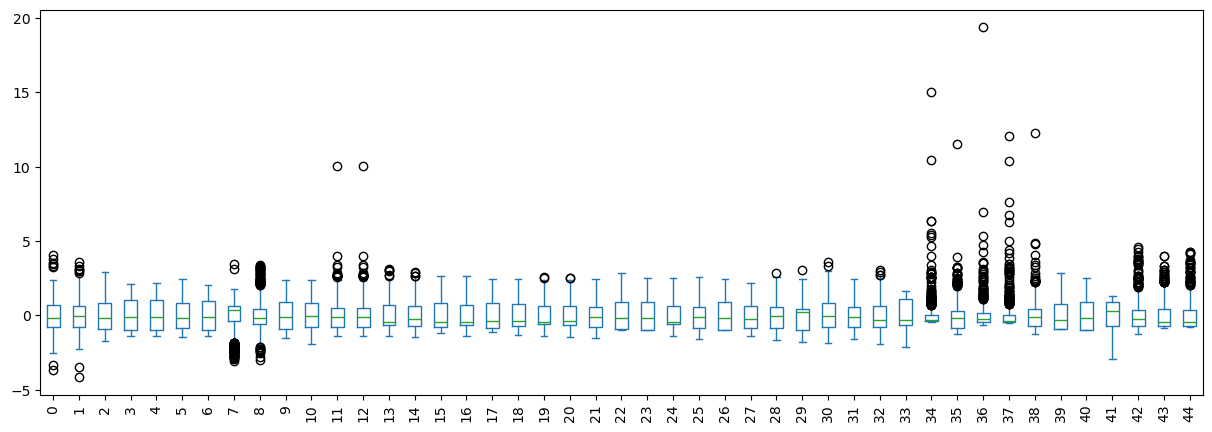

In [5]:
x_train.plot(kind='box', figsize=(15,5))
plt.xticks(rotation=90)
plt.show()

Cool. Veiem que algunes variables tenen força *outliers*.

Porto les dades a `numpy.ndarrays`.

In [6]:
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()

In [7]:
mlb = OneHotEncoder()

mlb.fit(y_train.reshape(-1,1))
y_train = mlb.transform(y_train.reshape(-1,1)).toarray()

Definim els dos models.

In [8]:
model1 = Sequential()

model1.add(Input(shape=x_train.shape[1],))
model1.add(Dense(15, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(4, activation='softmax'))


model2 = Sequential()
model2.add(Input(shape=x_train.shape[1], ))
model2.add(Dense(25, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(10, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(4, activation='softmax'))

Compilem els dos models.

In [9]:
model1.compile(loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics="accuracy")


model2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.legacy.Adam(),
              metrics="accuracy")

Faig el *fit* dels models, suprimint el *output* que és pesat i dificulta la lectura.

In [10]:
history1 = model1.fit(x_train, y_train, epochs=50, validation_split=0.2, 
                     batch_size = 10, verbose=0)

2024-01-28 22:46:52.074035: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [11]:
history2 = model2.fit(x_train, y_train, epochs=50, validation_split=0.2, 
                     batch_size = 10, verbose=0)

Grafico el procés de *training* dels dos models.

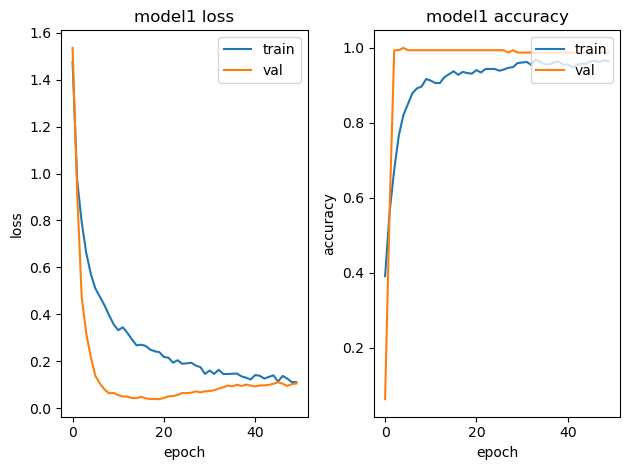

In [12]:
plt.subplot(1, 2, 1)

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(1,2,2)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.tight_layout()
plt.show()

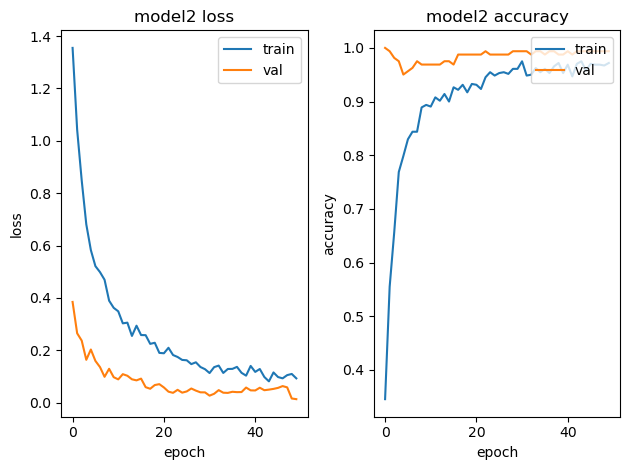

In [13]:
plt.subplot(1, 2, 1)

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(1,2,2)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.tight_layout()
plt.show()

Veiem que els dos models són molt semblants. A continuació realitzo les prediccions.

In [14]:
test_data = pd.read_csv('test_data.csv', index_col=0)
x_test = test_data.drop('ECG_signal', axis=1)
x_test = zscore_scaler.transform(x_test)


y_test = test_data.ECG_signal.to_numpy()
y_test = mlb.transform(y_test.reshape(-1,1)).toarray()

In [15]:
y_pred1 = model1.predict(x_test)
model1.evaluate(x_test,y_test)

13/13 [==============================] - 0s 430us/step - loss: 0.0922 - accuracy: 0.9724


[0.09216325730085373, 0.9724310636520386]

In [16]:
y_pred2 = model2.predict(x_test)
model2.evaluate(x_test, y_test)

13/13 [==============================] - 0s 377us/step - loss: 0.1041 - accuracy: 0.9774


[0.10414518415927887, 0.9774436354637146]

Amb aquest conjunt de dades, el model 2 mostra una millor *accuracy*. A continuació, desfaig el *one-hot encoding* per a poder crear les matrius de confusió. Les mostro, però recordeu que el anàlisi de veritat el duc a terme a l'informe generat amb `.Rmd`.

In [17]:
y_test = mlb.inverse_transform(y_test)
y_pred1 = mlb.inverse_transform(y_pred1)
y_pred2 = mlb.inverse_transform(y_pred2)

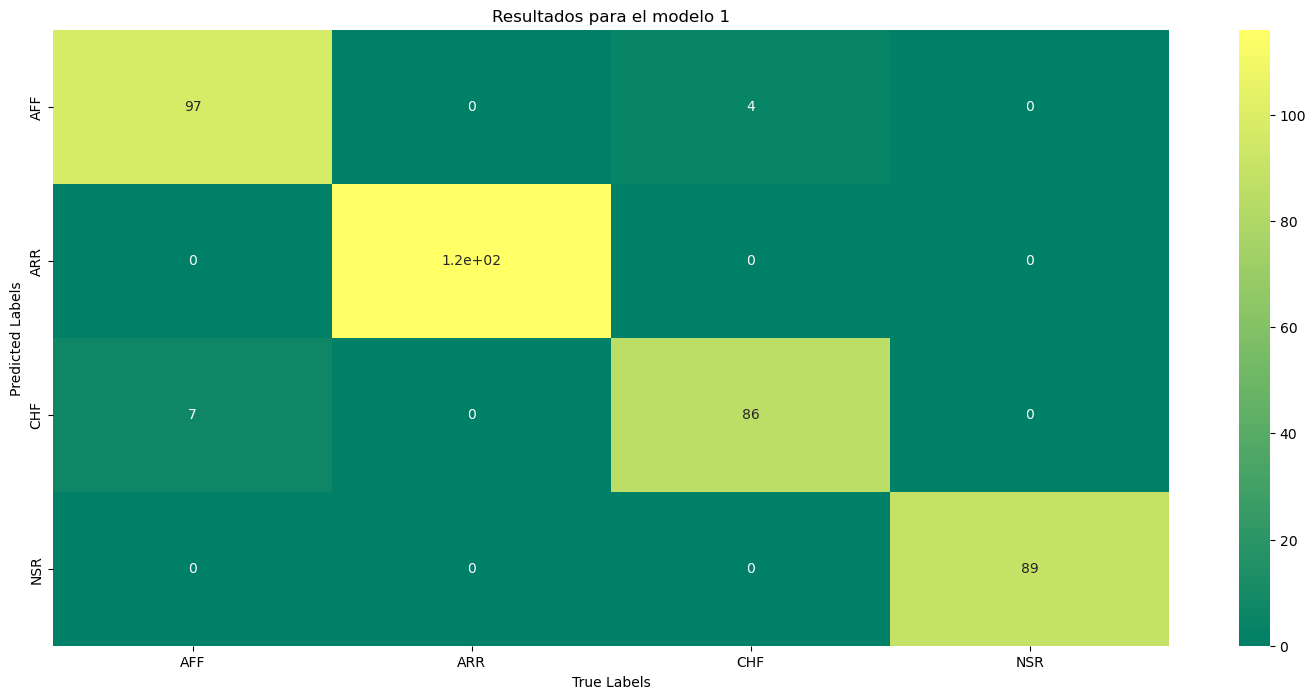

In [18]:
plt.figure(figsize = (18,8))
sns.heatmap(confusion_matrix(y_pred1, y_test), annot=True, 
            xticklabels = np.unique(y_test), 
            yticklabels = np.unique(y_test), cmap = 'summer')

plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Resultados para el modelo 1')
plt.show()

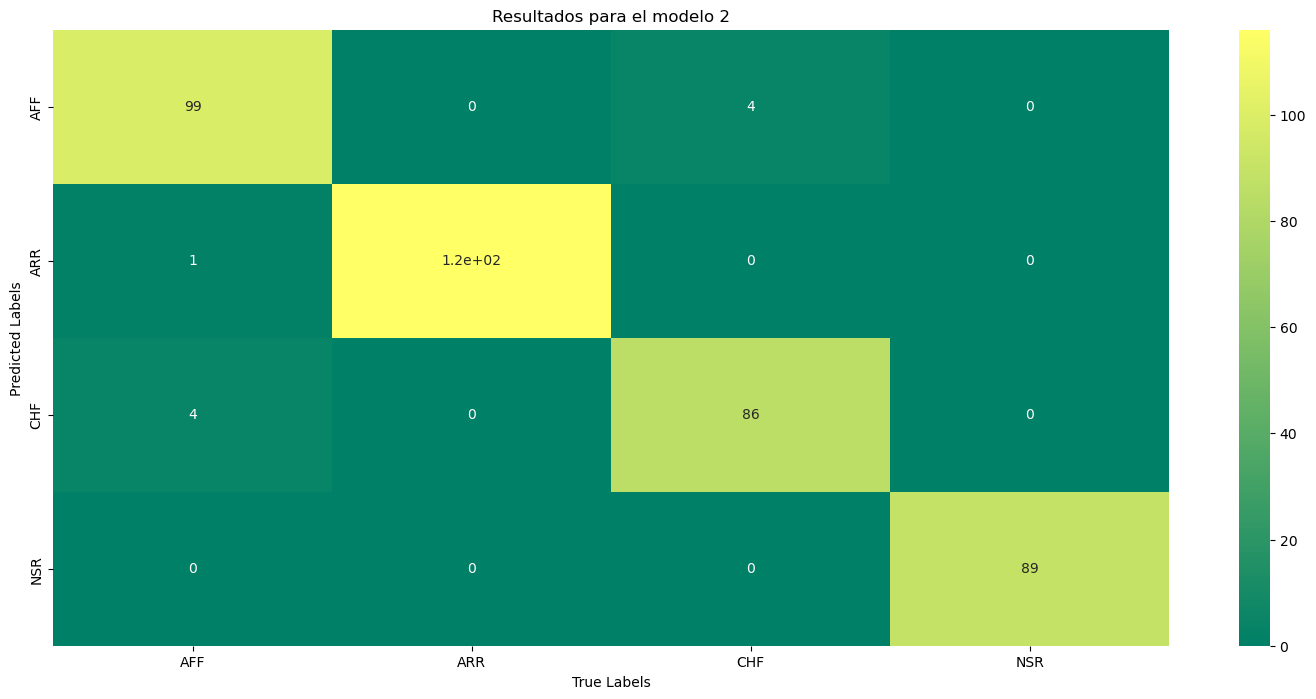

In [19]:
plt.figure(figsize = (18,8))
sns.heatmap(confusion_matrix(y_pred2, y_test), annot=True, 
            xticklabels = np.unique(y_test), 
            yticklabels = np.unique(y_test), cmap = 'summer')

plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Resultados para el modelo 2')
plt.show()

Podem mostrar també diferents mètriques per als dos models.

In [20]:
print(f"Precision score for model 2: {precision_score(y_test, y_pred2, average = 'macro')}")
print(f"Precision score for model 1: {precision_score(y_test, y_pred1, average='macro')}")
print('**********************************************')
print(f"Recall for model 2: {recall_score(y_test, y_pred2, average = 'macro')}")
print(f"Recall for model 1: {recall_score(y_test, y_pred1, average='macro')}")
print('**********************************************')
print(f"F-1 for model 2: {f1_score(y_test, y_pred2, average = 'macro')}")
print(f"F-1 for model 1: {f1_score(y_test, y_pred1, average = 'macro')}")

Precision score for model 2: 0.9770433988880591
Precision score for model 1: 0.9712818055999148
**********************************************
Recall for model 2: 0.9768696581196581
Recall for model 1: 0.9720619658119658
**********************************************
F-1 for model 2: 0.976946362298107
F-1 for model 1: 0.971558043449287


In [21]:
print('Resumen para el modelo 2\n')
print(classification_report(y_pred2, y_test)) 
print('*****************************************************\n') 
print('Resultados para el modelo 1\n') 
print(classification_report(y_pred1, y_test))

cm_nn2 = classification_report(y_pred2, y_test, output_dict=True)
cm_nn1 = classification_report(y_pred1, y_test, output_dict=True)

Resumen para el modelo 2

              precision    recall  f1-score   support

         AFF       0.95      0.96      0.96       103
         ARR       1.00      0.99      1.00       117
         CHF       0.96      0.96      0.96        90
         NSR       1.00      1.00      1.00        89

    accuracy                           0.98       399
   macro avg       0.98      0.98      0.98       399
weighted avg       0.98      0.98      0.98       399

*****************************************************

Resultados para el modelo 1

              precision    recall  f1-score   support

         AFF       0.93      0.96      0.95       101
         ARR       1.00      1.00      1.00       116
         CHF       0.96      0.92      0.94        93
         NSR       1.00      1.00      1.00        89

    accuracy                           0.97       399
   macro avg       0.97      0.97      0.97       399
weighted avg       0.97      0.97      0.97       399



Veiem que en totes les mètriques possibles """"guanya"""" marginalment el model 2.

Guardem els resultats a continuació.

In [22]:
if not os.path.exists('confusion_matrices'):
    os.mkdir('confusion_matrices')

In [23]:
pd.DataFrame(confusion_matrix(y_pred2, y_test, labels=np.unique(y_test)), 
             columns=np.unique(y_test)).to_csv('confusion_matrices/cm_nn2.csv')
pd.DataFrame(confusion_matrix(y_pred1, y_test, labels=np.unique(y_test)), 
             columns=np.unique(y_test)).to_csv('confusion_matrices/cm_nn1.csv')